In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install dcor

     |████████████████████████████████| 3.1MB 18.5MB/s 
     |████████████████████████████████| 24.6MB 1.8MB/s 
  Found existing installation: llvmlite 0.31.0
    Uninstalling llvmlite-0.31.0:
      Successfully uninstalled llvmlite-0.31.0
  Found existing installation: numba 0.48.0
    Uninstalling numba-0.48.0:
      Successfully uninstalled numba-0.48.0


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt, floor, ceil
from scipy import stats
from statistics import variance
from dcor import distance_correlation
# note: variance() == np.var(ddof=1) == sample variance

df = pd.read_excel('/content/drive/My Drive/Eng Stats project/COVID-19 Data for Project original.xlsx')
df = df.drop(0) # remove blank row
len(df)

/usr/local/lib/python3.6/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


1000

Impored dataframe mostly consists of the 'object' dtype. Need to convert dataframe columns to the relevant dtype that the column represents, so as to see descriptive statistics correctly.

In [ ]:
# convert dataframe columns to relevant dtype

toDate = ['SYMPTOMATIC ON', 'CONFIRMED ON', 'RECOVERED ON']
toNumeric = ['CASE', 'AGE', 'SYMPTOMATIC TO CONFIRMATION', 'DAYS TO RECOVER']
toCategory = ['GENDER', 'NATIONALITY', 'STATUS', 'DISPLAYED SYMPTOMS?']

df = df.replace({'-': None})

for column in toDate:
    df[column] = pd.to_datetime(df[column].loc[df[column] != None])

for column in toNumeric:
    df[column] = pd.to_numeric(df[column].loc[df[column] != None])

for column in toCategory:
    df[column] = df[column].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   CASE                         1000 non-null   float64       
 1   AGE                          999 non-null    float64       
 2   GENDER                       1000 non-null   category      
 3   NATIONALITY                  1000 non-null   category      
 4   STATUS                       1000 non-null   category      
 5   SYMPTOMATIC TO CONFIRMATION  240 non-null    float64       
 6   DAYS TO RECOVER              671 non-null    float64       
 7   SYMPTOMATIC ON               240 non-null    datetime64[ns]
 8   CONFIRMED ON                 1000 non-null   datetime64[ns]
 9   RECOVERED ON                 670 non-null    datetime64[ns]
 10  DISPLAYED SYMPTOMS?          1000 non-null   category      
dtypes: category(4), datetime64[ns](3), float64(

Note: DAYS TO RECOVER and RECOVERED ON **do not have the same count**.

In [ ]:
df[(df['RECOVERED ON'].isnull()) & (df['DAYS TO RECOVER'].notnull())]

,CASE,AGE,GENDER,NATIONALITY,STATUS,SYMPTOMATIC TO CONFIRMATION,DAYS TO RECOVER,SYMPTOMATIC ON,CONFIRMED ON,RECOVERED ON,DISPLAYED SYMPTOMS?
476,476.0,68.0,Male,Indonesian,Deceased,NaN,11.0,NaT,2020-03-22,NaT,1.0


In [ ]:
pd.set_option("display.max.columns", None)
df

,CASE,AGE,GENDER,NATIONALITY,STATUS,SYMPTOMATIC TO CONFIRMATION,DAYS TO RECOVER,SYMPTOMATIC ON,CONFIRMED ON,RECOVERED ON,DISPLAYED SYMPTOMS?
1,1.0,66.0,Male,Chinese,Recovered,3.0,26.0,2020-01-21,2020-01-23,2020-02-19,1.0
2,2.0,53.0,Female,Chinese,Recovered,3.0,14.0,2020-01-21,2020-01-24,2020-02-07,1.0
3,3.0,37.0,Male,Chinese,Recovered,1.0,27.0,2020-01-23,2020-01-24,2020-02-21,1.0
4,4.0,36.0,Male,Chinese,Recovered,3.0,17.0,2020-01-23,2020-01-25,2020-02-12,1.0
5,5.0,56.0,Female,Chinese,Recovered,4.0,21.0,2020-01-24,2020-01-27,2020-02-18,1.0
...,...,...,...,...,...,...,...,...,...,...,...
996,996.0,21.0,Female,Singaporean,In hospital,NaN,NaN,NaT,2020-04-01,NaT,1.0
997,997.0,50.0,Male,Indian,Recovered,NaN,14.0,NaT,2020-04-01,2020-04-15,1.0
998,998.0,31.0,Female,British,Recovered,NaN,8.0,NaT,2020-04-01,2020-04-09,1.0
999,999.0,21.0,Male,Singaporean,In hospital,NaN,NaN,NaT,2020-04-01,NaT,1.0


In [ ]:
df.describe()

,CASE,AGE,SYMPTOMATIC TO CONFIRMATION,DAYS TO RECOVER
count,1000.000000,999.000000,240.000000,671.000000
mean,500.500000,41.029029,6.054167,16.086438
std,288.819436,16.917285,4.774538,7.633096
min,1.000000,1.000000,0.000000,0.000000
25%,250.750000,27.000000,2.750000,11.000000
50%,500.500000,38.000000,5.000000,16.000000
75%,750.250000,54.000000,8.000000,20.000000
max,1000.000000,102.000000,33.000000,73.000000


In [ ]:
df.describe(include='category')

,GENDER,NATIONALITY,STATUS,DISPLAYED SYMPTOMS?
count,1000,1000,1000,1000.0
unique,2,35,3,2.0
top,Male,Singaporean,Recovered,1.0
freq,577,724,670,994.0


In [ ]:
df['DAYS TO RECOVER'].value_counts()
df[df['DAYS TO RECOVER'] == 0]

,CASE,AGE,GENDER,NATIONALITY,STATUS,SYMPTOMATIC TO CONFIRMATION,DAYS TO RECOVER,SYMPTOMATIC ON,CONFIRMED ON,RECOVERED ON,DISPLAYED SYMPTOMS?
151,151.0,51.0,Male,Singaporean,Recovered,33.0,0.0,2020-02-04,2020-03-08,2020-03-08,1.0


In [ ]:
df['AGE'].unique()

array([ 66.,  53.,  37.,  36.,  56.,  35.,  31.,  73.,  47.,  38.,  28.,
        48.,  44.,  41.,  17.,  32.,  40.,  42.,  45.,   1.,  27.,  39.,
        64.,  52.,  51.,  71.,  54.,   2.,  34.,  46.,  62.,  55.,  30.,
        26.,  61.,  57.,  50.,  79.,  25.,  43.,  29.,  24.,  75.,  58.,
        12.,  20.,  49.,  68.,  70.,  33.,  65.,  77.,  60.,  69.,  67.,
        59.,   5.,  83.,  76.,  22.,  63.,  78.,  86.,  23.,  19.,  72.,
        21.,  nan,  80.,  18.,  74.,   9.,  11.,   3.,   6.,  13.,  88.,
       102.,  85.,   7.])

**1) Plot a histogram showing the distribution of COVID-19 patients by age group, e.g. 0 – 10 years, 11 – 20 years, 21 – 30 years, etc. What is the average age to contract the virus?** **(4 marks)**

In [ ]:
ages = df['AGE'].loc[df['AGE'].notnull()]
print(len(ages))
print('Average age: ', ages.mean())

999
Average age:  41.029029029029026


(array([ 13.,  29., 273., 202., 155., 164., 110.,  37.,  15.,   0.,   1.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110]),
 <a list of 11 Patch objects>)

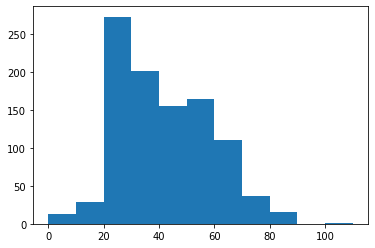

In [ ]:
plt.hist(ages, bins=[0,10,20,30,40,50,60,70,80,90,100,110])

**2) According to the data provided, is it true that males generally take longer to recover than females? How conclusive is your answer? (4 marks)**

In [ ]:
recovered = df[['GENDER', 'DAYS TO RECOVER']].loc[df['STATUS'] == 'Recovered']

# count sample size used
recovered_gender_count = recovered.groupby(['GENDER']).count()
print('Sample size: ', len(recovered))
print(recovered_gender_count.iloc[1].item(), 'males')
print(recovered_gender_count.iloc[0].item(), 'females', '\n')

# get mean values (displayed in 3 d.p.)
recovered_gender_mean = recovered.groupby(['GENDER']).mean()
print('Mean days for males: ', "{:.3f}".format(recovered_gender_mean.iloc[1].item()))
print('Mean days for females: ', "{:.3f}".format(recovered_gender_mean.iloc[0].item()))

# get median values (displayed in 3 d.p.)
recovered_gender_median = recovered.groupby(['GENDER']).median()
print('Median days for males: ', "{:.0f}".format(recovered_gender_median.iloc[1].item()))
print('Median days for females: ', "{:.0f}".format(recovered_gender_median.iloc[0].item()))

Sample size:  670
394 males
276 females 

Mean days for males:  16.259
Mean days for females:  15.859
Median days for males:  16
Median days for females:  15


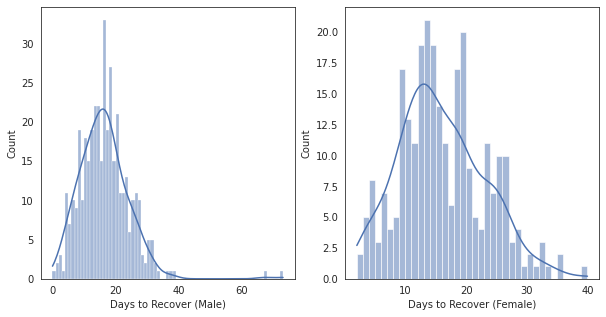

In [ ]:
sns.set_style("white")
sns.set_palette("deep")

recovered_males = recovered[recovered['GENDER'] == 'Male']
recovered_females = recovered[recovered['GENDER'] == 'Female']

# plot graphs
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.histplot(recovered_males, x="DAYS TO RECOVER", kde=True, binwidth=1, ax=ax1)
ax1.set(xlabel='Days to Recover (Male)', ylabel='Count')
sns.histplot(recovered_females, x="DAYS TO RECOVER", kde=True, binwidth=1, ax=ax2)
ax2.set(xlabel='Days to Recover (Female)', ylabel='Count')
plt.show()

In [ ]:
# sample variances
s1 = recovered_males['DAYS TO RECOVER']
s2 = recovered_females['DAYS TO RECOVER']
recovered_males_var = np.var(s1, ddof=1)
recovered_females_var = np.var(s2, ddof=1)
print('Sample variance (male): ', recovered_males_var)
print('Sample variance (female): ', recovered_females_var)

# scipy two-sample T test
t, p = stats.ttest_ind(a=s1, b=s2, equal_var=False)
print('t-statistic =', t)
print('p-value aka alpha =', p/2)

Sample variance (male):  64.10074785910795
Sample variance (female):  50.15814229249011
t-statistic = 0.6818934348408804
p-value aka alpha = 0.24777790473009131


In [ ]:
recovered_males_mean = np.mean(s1)
err = s1-recovered_males_mean
err_sq = err**2
err_sq.sum()
recovered_males_mean

16.258883248730964

In [ ]:
# define F test function
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) # calculate F test statistic 
    dfn = x.size - 1 # DOF numerator 
    dfd = y.size - 1 # DOF denominator 
    p = stats.f.sf(f, dfn, dfd) # find p-value of F test statistic 
    return f, p

# perform F test to test for unequal variances
f, p = f_test(s1, s2)
print('required f-statistic =', f)
print('alpha =', p)
print('confidence of unequal variances =', 100*(1-p), '%')

required f-statistic = 1.2779729258175778
alpha = 0.014650199811819722
confidence of unequal variances = 98.53498001881803 %


In [ ]:
# find estimated degrees of freedom for T statistic (unequal variance assumption)
kk = (recovered_males_var/394 + recovered_females_var/276)**2
kkk = ((recovered_males_var/394)**2 / 393) + ((recovered_females_var/276)**2 / 275)
DOF_est = floor(kk/kkk)
print('estimated DOF =', DOF_est)

# find value of alpha corresponding to maximum T statistic
recovered_males_mean = recovered_gender_mean.iloc[1].item()
recovered_females_mean = recovered_gender_mean.iloc[0].item()
q2_mean_point_est = recovered_males_mean - recovered_females_mean
t_half_alpha = q2_mean_point_est / sqrt(recovered_males_var/394 + recovered_females_var/276)
q2_alpha2 = stats.t.sf(t_half_alpha, DOF_est)
print('p-value calculated manually:', q2_alpha2)
print('confidence of miuM > miuF:', 100*(1-q2_alpha2))

estimated DOF = 632
p-value calculated manually: 0.24777807473486418
confidence of miuM > miuF: 75.22219252651358


**3) According to the data provided, is it true that males are less likely to recover (i.e. die from COVID-19), than females? How conclusive is your answer? (4 marks)**

In [ ]:
male_cases = df[['GENDER', 'STATUS']].loc[df['GENDER'] == 'Male']
female_cases = df[['GENDER', 'STATUS']].loc[df['GENDER'] == 'Female']

print('Male cases: ', len(male_cases))
print('Female cases: ', len(female_cases))

Male cases:  577
Female cases:  423


In [ ]:
# number of deceased by gender
dead = df[['GENDER', 'STATUS']].loc[df['STATUS'] == 'Deceased']
dead_count = dead.groupby('GENDER').count()
dead_count

,STATUS
GENDER,
Female,3
Male,5


In [ ]:
# find point estimate for p_male - p_female
nM = len(male_cases)
nF = len(female_cases)
xM = dead_count.iloc[1].item()
xF = dead_count.iloc[0].item()
p_male = xM / nM
p_female = xF / nF

p_est = p_male - p_female
print('point estimate =', p_est)

# find value of alpha corresponding to maximum Z statistic
q3_z = p_est / sqrt((p_male*(1-p_male)/nM) + (p_female*(1-p_female)/nF))
q3_alpha = stats.norm.sf(q3_z)
print('confidence of p_male > p_female:', 100*(1-q3_alpha), '%')

point estimate = 0.001573312683604361
confidence of p_male > p_female: 61.03247058882667 %


In [ ]:
# new method
pool_est = (xM + xF) / (nM + nF)
q3_z2 = p_est / sqrt((pool_est * (1-pool_est)) * (1/nM + 1/nF))
q3_alpha2 = stats.norm.sf(q3_z2)
print('alpha >', q3_alpha2)
print('confidence of p_male > p_female:', 100*(1-q3_alpha2), '%')

alpha > 0.3913074099418902
confidence of p_male > p_female: 60.869259005810974 %


**4) Estimate the mean number of days to recover with 95% confidence intervals. (4 marks)**

In [ ]:
q4_n = len(recovered)
recovered_mean = recovered['DAYS TO RECOVER'].mean()
recovered_var = np.var(recovered['DAYS TO RECOVER'], ddof=1)
q4_t = stats.t.isf(0.025, df=669)
q4_lower = recovered_mean - q4_t * sqrt(recovered_var/q4_n)
q4_upper = recovered_mean + q4_t * sqrt(recovered_var/q4_n)
print('95% confidence interval is:', q4_lower, '< miu <', q4_upper)

95% confidence interval is: 15.514763882068207 < miu < 16.67329581942433


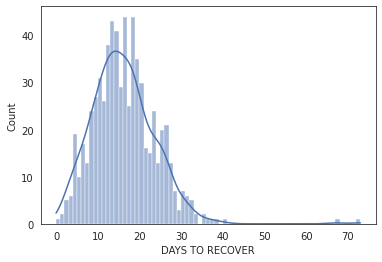

In [ ]:
q4_plot = recovered['DAYS TO RECOVER']
sns.histplot(q4_plot, kde=True, binwidth=1,)

**5) According to the data provided, is it true that a Singaporean (nationality-wise) male is more likely to contract COVID-19 than a Singaporean female? How conclusive is your answer? (4 marks)**

In [ ]:
# number of SG male and female cases
sg_cases = df['GENDER'].loc[df['NATIONALITY'] == 'Singaporean']
sg_males = sg_cases[sg_cases == 'Male']
sg_females = sg_cases[sg_cases == 'Female']
print('No. of SG males =', len(sg_males))
print('No. of SG females =', len(sg_females))

No. of SG males = 400
No. of SG females = 324


In [ ]:
# find value of alpha corresponding to maximum Z statistic
p_sgm = len(sg_males) / len(sg_cases)
n = len(sg_cases)
q5_z = (p_sgm - 0.5) / (sqrt(p_sgm*(1-p_sgm)/n))
q5_alpha = stats.norm.sf(q5_z)
print('alpha =', q5_alpha)
print('confidence of proportion exceeding 0.5:', 100*(1-q5_alpha), '%')

alpha = 0.0022541955869423646
confidence of proportion exceeding 0.5: 99.77458044130576 %


In [ ]:
q5_z2 = (p_sgm - 0.5) / sqrt(0.5*(1-0.5)/724)
q5_alpha2 = stats.norm.sf(q5_z2)
print(q5_z2)
print('alpha =', q5_alpha2)
print('confidence of proportion exceeding 0.5:', 100*(1-q5_alpha2), '%')

2.8245177557392336
alpha = 0.00236759123028613
confidence of proportion exceeding 0.5: 99.76324087697138 %


**6) According to the data, is it true that a COVID-19 patient at or above the age of 50 takes longer to recover than a patient who is younger than 50? How conclusive is your answer? (4 marks)**

In [ ]:
# check which row does not contain age
df[df['AGE'].isnull()]

,CASE,AGE,GENDER,NATIONALITY,STATUS,SYMPTOMATIC TO CONFIRMATION,DAYS TO RECOVER,SYMPTOMATIC ON,CONFIRMED ON,RECOVERED ON,DISPLAYED SYMPTOMS?
282,282.0,NaN,Male,Unidentified nationality,Recovered,NaN,18.0,NaT,2020-03-17,2020-04-04,1.0


In [ ]:
recovered2 = (df[['AGE', 'DAYS TO RECOVER']]
              .loc[df['STATUS'] == 'Recovered']
              .loc[df['AGE'].notnull()] # only choose rows containing age
)

recovered_old = recovered2['DAYS TO RECOVER'].loc[recovered2['AGE'] >= 50]
recovered_young = recovered2['DAYS TO RECOVER'].loc[recovered2['AGE'] < 50]

# count sample size used
print('Sample size: ', len(recovered2))
print(len(recovered_old), 'patients at/above 50')
print(len(recovered_young), 'patients under 50', '\n')

# get mean values (displayed in 3 d.p.)
recovered_old_mean = recovered_old.mean()
recovered_young_mean = recovered_young.mean()
print('Mean days for at/above 50: ', "{:.3f}".format(recovered_old_mean))
print('Mean days for below 50: ', "{:.3f}".format(recovered_young_mean))
print('Point estimate =', "{:.3f}".format(recovered_old_mean - recovered_young_mean))

# get median values (displayed in 3 d.p.)
recovered_old_median = recovered_old.median()
recovered_young_median = recovered_young.median()
print('Median days for at/above 50: ', "{:.3f}".format(recovered_old_median))
print('Median days for below 50: ', "{:.3f}".format(recovered_young_median))

# get sample variance (displayed in 3 d.p.)
recovered_old_var = recovered_old.var(ddof=1)
recovered_young_var = recovered_young.var(ddof=1)
print('Sample variance for at/above 50: ', "{:.3f}".format(recovered_old_var))
print('Sample variance for below 50: ', "{:.3f}".format(recovered_young_var))

Sample size:  669
236 patients at/above 50
433 patients under 50 

Mean days for at/above 50:  16.712
Mean days for below 50:  15.753
Point estimate = 0.959
Median days for at/above 50:  16.000
Median days for below 50:  15.000
Sample variance for at/above 50:  80.580
Sample variance for below 50:  46.136


In [ ]:
# perform F test to test for unequal variances
f, p = f_test(recovered_old, recovered_young)
print('required f-statistic =', f)
print('alpha =', p)
print('confidence of unequal variances =', 100*(1-p), '%')

required f-statistic = 1.7466021139903123
alpha = 3.2089927927047514e-07
confidence of unequal variances = 99.99996791007207 %


In [ ]:
# find estimated degrees of freedom for T statistic (unequal variance assumption)
kk2 = (recovered_old_var/236 + recovered_young_var/433)**2
kkk2 = ((recovered_old_var/236)**2 / 235) + ((recovered_young_var/433)**2 / 432)
q6_DOF_est = floor(kk2/kkk2)
print('estimated DOF =', DOF_est)

# find value of alpha corresponding to maximum T statistic
q6_mean_point_est = recovered_old_mean - recovered_young_mean
q6_t_half_alpha = q6_mean_point_est / sqrt(recovered_old_var/236 + recovered_young_var/433)
q6_alpha2 = stats.t.sf(q6_t_half_alpha, q6_DOF_est)
print(q6_t_half_alpha, q6_alpha2)
print('p-value calculated manually:', q6_alpha2)
print('confidence of miuA > miuB:', 100*(1-q6_alpha2), '%')

estimated DOF = 632
1.4327608179355817 0.07636989171026315
p-value calculated manually: 0.07636989171026315
confidence of miuA > miuB: 92.36301082897369 %


In [ ]:
# scipy two-sample T test
t,p = stats.ttest_ind(recovered_old, recovered_young, equal_var=False)
print('0.5*p-value given by SciPy:', p/2)

0.5*p-value given by SciPy: 0.07636968253282923


# Part 2: COVID-19 in Singapore and overseas

In [ ]:
df2 = pd.read_excel('/content/drive/My Drive/Eng Stats project/COVID-19 Data for Project original.xlsx',
                    sheet_name=1)
df2.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df2['Date'] = pd.to_datetime(df2['Date'])
df2.tail()

,Date,Singapore,China,UK,US
211,2020-07-29,359,207,70,61734
212,2020-07-30,334,223,763,74985
213,2020-07-31,278,276,846,68032
214,2020-08-01,396,166,880,67023
215,2020-08-02,307,165,771,58407


In [ ]:
df2.describe()

,Singapore,China,UK,US
count,216.000000,216.000000,216.000000,216.000000
mean,243.111111,406.574074,1407.185185,21390.944444
std,284.577168,1286.753092,1668.086051,21489.200516
min,0.000000,0.000000,0.000000,0.000000
25%,3.000000,9.750000,1.000000,1.000000
50%,146.500000,38.000000,723.500000,20698.000000
75%,401.000000,136.500000,2412.750000,30574.000000
max,1426.000000,15141.000000,5487.000000,78427.000000


**7) How does the daily number of new cases in Singapore correlate to the daily number of new cases in China, United Kingdom and United States, respectively? (4 marks)**

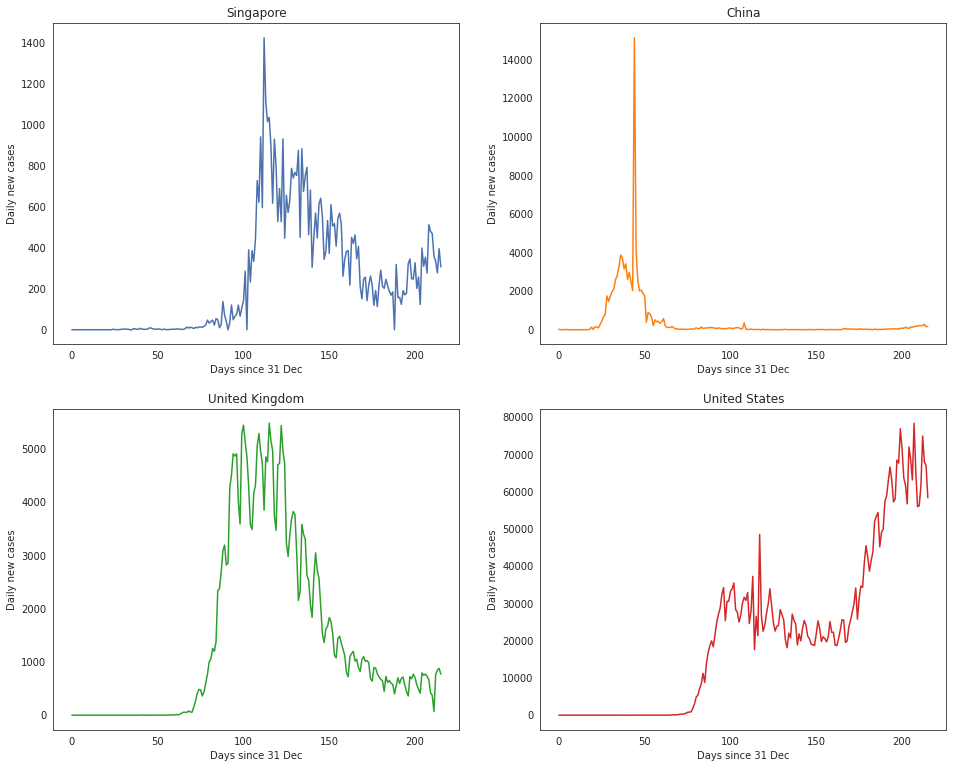

In [ ]:
sg = df2['Singapore']
cn = df2['China']
uk = df2['UK']
us = df2['US']
countries = [sg, cn, uk, us]
country_names = ['Singapore', 'China', 'UK', 'US']

def q7_plot():
    fig, axs = plt.subplots(2,2, figsize=(16,13))
    axs[0, 0].plot(sg)
    axs[0, 0].set_title('Singapore')
    axs[0, 1].plot(cn, 'tab:orange')
    axs[0, 1].set_title('China')
    axs[1, 0].plot(uk, 'tab:green')
    axs[1, 0].set_title('United Kingdom')
    axs[1, 1].plot(us, 'tab:red')
    axs[1, 1].set_title('United States')

    for ax in axs.flat:
        ax.set(xlabel='Days since 31 Dec', ylabel='Daily new cases')

    return plt.show()

q7_plot()

In [ ]:
sg.corr(cn, method='spearman')

-0.37316254351062855

In [ ]:
# compute pearson, spearman, distance correlations for each relationship
def q7_correlations():
  for country in zip(country_names[1:], countries[1:]):
      print(country[0])
      pearson = sg.corr(country[1])
      spearman = stats.spearmanr(sg, country[1]).correlation
      kendall = stats.kendalltau(sg, country[1]).correlation
      d_cor = distance_correlation(sg, country[1])

      print('Pearson:', pearson)
      print('Spearman:', spearman)
      print('Kendall:', kendall)
      print('Distance correlation:', d_cor)
      print()

q7_correlations()

China
Pearson: -0.24266500096603189
Spearman: -0.37316254351062855
Kendall: -0.29202636861769277
Distance correlation: 0.38465154571980575

UK
Pearson: 0.6416816340950443
Spearman: 0.7918328469451746
Kendall: 0.6377009359608001
Distance correlation: 0.6560873068473757

US


/usr/local/lib/python3.6/dist-packages/dcor/_fast_dcov_avl.py:317: UserWarning: Falling back to uncompiled AVL fast distance covariance because of TypeError exception raised: No matching definition for argument type(s) array(int64, 1d, C), array(int64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(f"Falling back to uncompiled AVL fast distance "


Pearson: 0.41314516793899747
Spearman: 0.6741815622222951
Kendall: 0.49604016286660724
Distance correlation: 0.6778751779509736



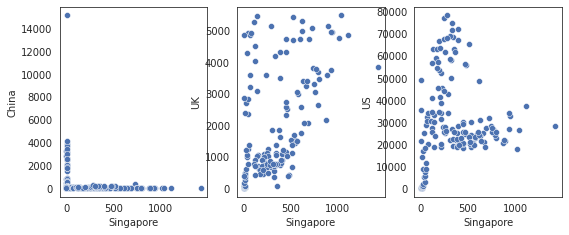

In [ ]:
def q7_plot2():
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3.5))
    sns.scatterplot(x=sg, y=cn, ax=ax1)
    ax1.set(xlabel='Singapore', ylabel='China')
    sns.scatterplot(x=sg, y=uk, ax=ax2)
    ax2.set(xlabel='Singapore', ylabel='UK')
    sns.scatterplot(x=sg, y=us, ax=ax3)
    ax3.set(xlabel='Singapore', ylabel='US')
    return plt.show()

q7_plot2()

**8) When COVID-19 spreads from one country to another, we may see some similarity in the behaviour of the outbreaks. For example, the number of new cases in Singapore may not correlate well with the number of new cases in China on a same-day basis, but may correlate better with the number of new cases in China x days ago. Find out the values of x that maximise the correlation between the number of new cases in Singapore and the number of new cases in China, United Kingdom and United States, respectively. Explain the method used to determine x and the assumptions made with justifications. Solutions that use an automated algorithm to find out x will score more marks (of course, you need to clearly explain the algorithm used and how it is computationally implemented). (8 marks)**

In [ ]:
def q8_algorithm(other_country):
    
    result = np.correlate(sg, other_country, 'full')
    max_position = np.argmax(result) + 1
    max_k = max_position - ceil(result.size/2)

    return max_k

other_countries = [[cn, 'China'], [uk, 'UK'], [us, 'US']]

for country_code, country in other_countries:
    x = q8_algorithm(country_code)
    print('For {}, x = {}'.format(country, x))

For China, x = 79
For UK, x = 15
For US, x = -63


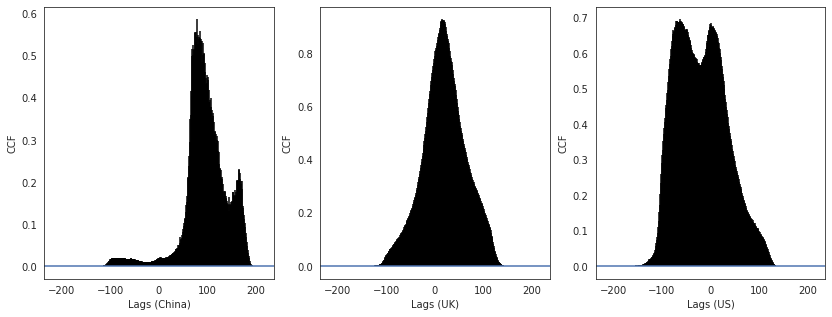

In [ ]:
def corrplot():
    a = np.array(sg, dtype=float)
    b = np.array(cn, dtype=float)
    c = np.array(uk, dtype=float)
    d = np.array(us, dtype=float)
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,5))
    ax1.xcorr(a, b, maxlags=None)
    ax1.set(xlabel='Lags (China)', ylabel='CCF')
    ax2.xcorr(a, c, maxlags=None)
    ax2.set(xlabel='Lags (UK)', ylabel='CCF')
    ax3.xcorr(a, d, maxlags=None)
    ax3.set(xlabel='Lags (US)', ylabel='CCF')
    return plt.show()

corrplot()